In [327]:
import re
from io import StringIO
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import neurokit2 as nk

import mne

In [359]:
import re
from pathlib import Path
from datetime import datetime, timedelta

directory_path = Path("E:/Mitra/liquid-effect-on-eeg-analysis/assets/bio") 
session_times = {}  
for file_path in directory_path.glob("*.txt"):
    with open(file_path, 'r') as file:
        session_time = None
        end_time = None

        for line in file:
            session_match = re.search(r"Session Time:\s+([\d:]+\s[APM]+)", line)
            if session_match:
                session_time = session_match.group(1)
            
            end_match = re.search(r"End Time:\s+([\d:]+\.\d+)", line)
            if end_match:
                end_time = end_match.group(1)
            
            if session_time and end_time:
                break

        if session_time and end_time:
            session_dt = datetime.strptime(session_time, "%I:%M:%S %p")
            end_dt = datetime.strptime(end_time, "%H:%M:%S.%f")

            time_difference = session_dt - end_dt
            total_seconds = int(time_difference.total_seconds())
            hours, remainder = divmod(total_seconds, 3600)
            minutes, seconds = divmod(remainder, 60)
            formatted_difference = f"{hours:02}:{minutes:02}:{seconds:02}"
            session_times[file_path.stem] = formatted_difference

for participant, time_diff in session_times.items():
    print(f"{participant}: {time_diff}")

Atousa Norouzian: 09:37:25
Fatemeh Hosseini: 11:16:59
Fatemeh Sadeghian: 10:49:55
Fatemeh Saleh: 10:31:31
Kian Darabi: 11:07:26
MohammadAli HesariNezhad: 10:00:15
Mona Kaveh: 13:30:16
Noura Tavakori: 14:16:18
Reyhaneh Hosseini: 11:16:59
Zahra Ahmadi: 08:53:15


In [76]:
import json

p = {}
# assets = Path("../assets/pilot")
assets = Path("E:/Mitra/liquid-effect-on-eeg-analysis/assets/pilot")
for person_dir in assets.iterdir():
    info = person_dir / "info.json"
    with info.open("r") as file:
        data = json.load(file)
        full_name = f"{data['name']} {data['lastname']}"
        p[full_name] = data
    p[full_name]["eeg"] = {}
    for edf_file in person_dir.glob("*.edf"):
        p[full_name]["eeg"][edf_file.stem] = mne.io.read_raw_edf(edf_file, verbose=False, exclude=["event"]) \
            .rename_channels(lambda x: x.replace('EEG ', '')) \
            .set_montage(mne.channels.make_standard_montage("standard_1020"))

print("\n".join(p.keys()))

Zahra Ahmadi
Kian Darabi
Fatemeh Saleh
Fatemeh Sadeghian
Fatemeh Hosseini
Reyhaneh Hosseini
MohammadAli HesariNezhad
Mona Kaveh
Atousa Norouzian
Noura Tavakori


In [368]:
from datetime import datetime, timedelta

state_result = {}

for subject, data in p.items():
    states = {}
    for file_name, eeg_data in data["eeg"].items():
        start = eeg_data.info['meas_date'].replace(microsecond=0)
        end = start + timedelta(seconds=eeg_data.times[-1])
        start_time = start.strftime("%H:%M:%S")
        states[file_name] = {
            'start': start_time,
            'end': end.strftime("%H:%M:%S"),
        }

    sorted_states = sorted(states.items(), key=lambda x: datetime.strptime(x[1]['start'], "%H:%M:%S"))
    if subject in session_times:
        reference_time = datetime.strptime(session_times[subject], "%H:%M:%S")

    adjusted_states = []
    for file_name, times in sorted_states:
        start_seconds = (datetime.strptime(times['start'], "%H:%M:%S") - reference_time).total_seconds()
        end_seconds = (datetime.strptime(times['end'], "%H:%M:%S") - reference_time).total_seconds()

        start_display = f"{int(start_seconds)}s"  
        end_display = f"{int(end_seconds)}s"      

        adjusted_states.append({
            'name': file_name,
            'start': start_display,
            'end': end_display
        })

    state_result[subject] = {
        'states': adjusted_states
    }

display(state_result)

{'Zahra Ahmadi': {'states': [{'name': 'rest', 'start': '-73s', 'end': '228s'},
   {'name': 's', 'start': '229s', 'end': '538s'},
   {'name': 't', 'start': '539s', 'end': '835s'}]},
 'Kian Darabi': {'states': [{'name': 't', 'start': '-15s', 'end': '308s'},
   {'name': 's', 'start': '309s', 'end': '630s'},
   {'name': 'rest_', 'start': '630s', 'end': '854s'}]},
 'Fatemeh Saleh': {'states': [{'name': 'rest', 'start': '-82s', 'end': '164s'},
   {'name': 's_', 'start': '194s', 'end': '412s'},
   {'name': 't', 'start': '412s', 'end': '637s'}]},
 'Fatemeh Sadeghian': {'states': [{'name': 'rest',
    'start': '-30s',
    'end': '214s'},
   {'name': 's', 'start': '214s', 'end': '449s'},
   {'name': 't', 'start': '449s', 'end': '634s'}]},
 'Fatemeh Hosseini': {'states': [{'name': 'rest',
    'start': '-8894s',
    'end': '-8719s'},
   {'name': 's', 'start': '-8719s', 'end': '-8541s'},
   {'name': 't', 'start': '-8540s', 'end': '-8325s'}]},
 'Reyhaneh Hosseini': {'states': [{'name': 'rest',
    '

In [375]:
from datetime import datetime, timedelta

state_result = {}

for subject, data in p.items():
    states = {}
    
    for file_name, eeg_data in data["eeg"].items():
        start = eeg_data.info['meas_date'].replace(microsecond=0)
        end = start + timedelta(seconds=eeg_data.times[-1])
        start_time = start.strftime("%H:%M:%S")
        
        states[file_name] = {
            'start': start_time,
            'end': end.strftime("%H:%M:%S"),
        }
    
    sorted_states = sorted(states.items(), key=lambda x: datetime.strptime(x[1]['start'], "%H:%M:%S"))
    display(sorted_states)
    state_result[subject] = {
        'states': [
            {
                'name': state[0],  
                'start': state[1]['start'],
                'end': state[1]['end'],
            } for state in sorted_states
        ]
    }

# Print the result
import pprint
pprint.pprint(state_result)


[('rest', {'start': '08:52:02', 'end': '08:57:03'}),
 ('s', {'start': '08:57:04', 'end': '09:02:13'}),
 ('t', {'start': '09:02:14', 'end': '09:07:10'})]

[('t', {'start': '11:07:11', 'end': '11:12:34'}),
 ('s', {'start': '11:12:35', 'end': '11:17:56'}),
 ('rest_', {'start': '11:17:56', 'end': '11:21:40'})]

[('rest', {'start': '10:30:09', 'end': '10:34:15'}),
 ('s_', {'start': '10:34:45', 'end': '10:38:23'}),
 ('t', {'start': '10:38:23', 'end': '10:42:08'})]

[('rest', {'start': '10:49:25', 'end': '10:53:29'}),
 ('s', {'start': '10:53:29', 'end': '10:57:24'}),
 ('t', {'start': '10:57:24', 'end': '11:00:29'})]

[('rest', {'start': '08:48:45', 'end': '08:51:40'}),
 ('s', {'start': '08:51:40', 'end': '08:54:38'}),
 ('t', {'start': '08:54:39', 'end': '08:58:14'})]

[('rest', {'start': '11:16:20', 'end': '11:21:34'}),
 ('t', {'start': '11:29:00', 'end': '11:32:05'}),
 ('s', {'start': '11:38:05', 'end': '11:41:08'})]

[('rest', {'start': '10:00:09', 'end': '10:03:26'}),
 ('t', {'start': '10:03:26', 'end': '10:06:39'}),
 ('s', {'start': '10:06:39', 'end': '10:09:47'})]

[('rest', {'start': '13:30:04', 'end': '13:35:16'}),
 ('s', {'start': '13:42:15', 'end': '13:45:27'}),
 ('t', {'start': '13:51:17', 'end': '13:54:37'})]

[('rest', {'start': '09:36:29', 'end': '09:39:44'}),
 ('t', {'start': '09:39:44', 'end': '09:43:09'}),
 ('s', {'start': '09:43:09', 'end': '09:47:23'})]

[('rest', {'start': '14:12:53', 'end': '14:17:56'}),
 ('t', {'start': '14:17:57', 'end': '14:21:03'})]

{'Atousa Norouzian': {'states': [{'end': '09:39:44',
                                  'name': 'rest',
                                  'start': '09:36:29'},
                                 {'end': '09:43:09',
                                  'name': 't',
                                  'start': '09:39:44'},
                                 {'end': '09:47:23',
                                  'name': 's',
                                  'start': '09:43:09'}]},
 'Fatemeh Hosseini': {'states': [{'end': '08:51:40',
                                  'name': 'rest',
                                  'start': '08:48:45'},
                                 {'end': '08:54:38',
                                  'name': 's',
                                  'start': '08:51:40'},
                                 {'end': '08:58:14',
                                  'name': 't',
                                  'start': '08:54:39'}]},
 'Fatemeh Sadeghian': {'states': [{'end': '10:53:29',


In [370]:
def parse_file(file_path):
    with open(file_path) as file:
        content = file.read()
    
    client_name = re.search(r'Client:\s*(.+?)\s*Channel Set:', content).group(1).strip()
    csv_part = content.split('\n\n')[2].strip()
    
    raw = pd.read_csv(StringIO(csv_part)).drop(index=0).reset_index(drop=True)["E: Skin Cond"]
    eda, info = nk.eda_process(raw, sampling_rate=256, report=client_name)    
    return client_name, eda, info

In [371]:
def eda_plot_dashedsegments(
    eda_signals, ax, x_axis, onsets, peaks, half_recovery
):
    # Mark onsets, peaks, and half-recovery.
    onset_x_values = x_axis[onsets]
    onset_y_values = eda_signals["EDA_Phasic"][onsets].values
    peak_x_values = x_axis[peaks]
    peak_y_values = eda_signals["EDA_Phasic"][peaks].values
    halfr_x_values = x_axis[half_recovery]
    halfr_y_values = eda_signals["EDA_Phasic"][half_recovery].values

    end_onset = pd.Series(
        eda_signals["EDA_Phasic"][onsets].values, eda_signals["EDA_Phasic"][peaks].index
    )

    risetime_coord = []
    amplitude_coord = []
    halfr_coord = []

    for i in range(len(onsets)):
        # Rise time.
        start = (onset_x_values[i], onset_y_values[i])
        end = (peak_x_values[i], onset_y_values[i])
        risetime_coord.append((start, end))

    for i in range(len(peaks)):
        # SCR Amplitude.
        start = (peak_x_values[i], onset_y_values[i])
        end = (peak_x_values[i], peak_y_values[i])
        amplitude_coord.append((start, end))

    for i in range(len(half_recovery)):
        # Half recovery.
        end = (halfr_x_values[i], halfr_y_values[i])
        peak_x_idx = np.where(peak_x_values < halfr_x_values[i])[0][-1]
        start = (peak_x_values[peak_x_idx], halfr_y_values[i])
        halfr_coord.append((start, end))


    # Plot with matplotlib.
    # Mark onsets, peaks, and half-recovery.
    ax.scatter(
        x_axis[onsets],
        eda_signals["EDA_Phasic"][onsets],
        color="#FFA726",
        label="SCR - Onsets",
        zorder=2,
    )
    ax.scatter(
        x_axis[peaks],
        eda_signals["EDA_Phasic"][peaks],
        color="#1976D2",
        label="SCR - Peaks",
        zorder=2,
    )
    ax.scatter(
        x_axis[half_recovery],
        eda_signals["EDA_Phasic"][half_recovery],
        color="#FDD835",
        label="SCR - Half recovery",
        zorder=2,
    )

    ax.scatter(x_axis[end_onset.index], end_onset.values, alpha=0)

    return risetime_coord, amplitude_coord, halfr_coord

In [372]:
def plot_data(eda_signal, info, name):
    peaks = np.where(eda_signals["SCR_Peaks"] == 1)[0]
    onsets = np.where(eda_signals["SCR_Onsets"] == 1)[0]
    half_recovery = np.where(eda_signals["SCR_Recovery"] == 1)[0]
    
    # clean peaks that do not have onsets
    if len(peaks) > len(onsets):
        peaks = peaks[1:]
    
    # Determine unit of x-axis.
    x_label = "Time (seconds)"
    x_axis = np.linspace(0, len(eda_signals) / info["sampling_rate"], len(eda_signals))
    
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(14, 8))
    
    last_ax = fig.get_axes()[-1]
    last_ax.set_xlabel(x_label)
    
    # Plot cleaned and raw electrodermal activity.
    ax0.set_title("Raw and Cleaned Signal")
    fig.suptitle(f"Electrodermal Activity (EDA) - {name}", fontweight="bold")
    
    ax0.plot(x_axis, eda_signals["EDA_Raw"], color="#B0BEC5", label="Raw", zorder=1)
    ax0.plot(
        x_axis,
        eda_signals["EDA_Clean"],
        color="#9C27B0",
        label="Cleaned",
        linewidth=1.5,
        zorder=1,
    )
    ax0.legend(loc="upper right")
    
    # Plot skin conductance response.
    ax1.set_title("Skin Conductance Response (SCR)")
    
    # Plot Phasic.
    ax1.plot(
        x_axis,
        eda_signals["EDA_Phasic"],
        color="#E91E63",
        label="Phasic Component",
        linewidth=1.5,
        zorder=1,
    )
    
    # Mark segments.
    risetime_coord, amplitude_coord, halfr_coord = eda_plot_dashedsegments(
        eda_signals, ax1, x_axis, onsets, peaks, half_recovery
    )
    
    risetime = matplotlib.collections.LineCollection(
        risetime_coord, colors="#FFA726", linewidths=1, linestyle="dashed"
    )
    ax1.add_collection(risetime)
    
    amplitude = matplotlib.collections.LineCollection(
        amplitude_coord, colors="#1976D2", linewidths=1, linestyle="solid"
    )
    ax1.add_collection(amplitude)
    
    halfr = matplotlib.collections.LineCollection(
        halfr_coord, colors="#FDD835", linewidths=1, linestyle="dashed"
    )
    ax1.add_collection(halfr)
    ax1.legend(loc="upper right")
    
    # Plot Tonic.
    ax2.set_title("Skin Conductance Level (SCL)")
    ax2.plot(
        x_axis,
        eda_signals["EDA_Tonic"],
        color="#673AB7",
        label="Tonic Component",
        linewidth=1.5,
    )
    
    ax2.legend(loc="upper right") 
    name = name.split('-')[-1].split('-')[0].strip()
    print(name)

    if name in state_result:
        y_min, y_max = ax2.get_ylim()
        pos_y = y_min + 0.1 * (y_max - y_min) 
        for state_info in state_result[name]['states']:
            start = int(state_info['start'].replace("s", ""))
            end = int(state_info['end'].replace("s", ""))
            ax2.axvline(x=start, color="black", linestyle="--", label=f"{state_info['name']} start")
            ax2.axvline(x=end, color="red", linestyle="-.", label=f"{state_info['name']} end")
            pos_x = (start + end) / 2 
            ax2.text(pos_x, pos_y, f"{state_info['name']}", fontsize=10, color="black")

    # fig.savefig(f"../assets/bio-plots/{name}.png", dpi=300, bbox_inches="tight")
    fig.savefig(f"E:/Mitra/liquid-effect-on-eeg-analysis/assets/bio/{name}.png", dpi=300, bbox_inches="tight")

C:\Users\mitra\AppData\Local\Temp\ipykernel_13676\2285612441.py:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  raw = pd.read_csv(StringIO(csv_part)).drop(index=0).reset_index(drop=True)["E: Skin Cond"]


The raw signal, sampled at 256 Hz, was cleaned using the default method of the neurokit2 package.

The signal was decomposed into phasic and tonic components using the method described in neurokit.

The cleaned signal was used to detect peaks using the default method of the `neurokit2` package.



References
- https://doi.org/10.21105/joss.01667
Atousa Norouzian


C:\Users\mitra\AppData\Local\Temp\ipykernel_13676\2285612441.py:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  raw = pd.read_csv(StringIO(csv_part)).drop(index=0).reset_index(drop=True)["E: Skin Cond"]


The raw signal, sampled at 256 Hz, was cleaned using the default method of the neurokit2 package.

The signal was decomposed into phasic and tonic components using the method described in neurokit.

The cleaned signal was used to detect peaks using the default method of the `neurokit2` package.



References
- https://doi.org/10.21105/joss.01667
Fatemeh Hosseini


C:\Users\mitra\AppData\Local\Temp\ipykernel_13676\2285612441.py:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  raw = pd.read_csv(StringIO(csv_part)).drop(index=0).reset_index(drop=True)["E: Skin Cond"]


The raw signal, sampled at 256 Hz, was cleaned using the default method of the neurokit2 package.

The signal was decomposed into phasic and tonic components using the method described in neurokit.

The cleaned signal was used to detect peaks using the default method of the `neurokit2` package.



References
- https://doi.org/10.21105/joss.01667
Fatemeh Sadeghian


C:\Users\mitra\AppData\Local\Temp\ipykernel_13676\2285612441.py:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  raw = pd.read_csv(StringIO(csv_part)).drop(index=0).reset_index(drop=True)["E: Skin Cond"]


The raw signal, sampled at 256 Hz, was cleaned using the default method of the neurokit2 package.

The signal was decomposed into phasic and tonic components using the method described in neurokit.

The cleaned signal was used to detect peaks using the default method of the `neurokit2` package.



References
- https://doi.org/10.21105/joss.01667
Fatemeh Saleh


C:\Users\mitra\AppData\Local\Temp\ipykernel_13676\2285612441.py:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  raw = pd.read_csv(StringIO(csv_part)).drop(index=0).reset_index(drop=True)["E: Skin Cond"]


The raw signal, sampled at 256 Hz, was cleaned using the default method of the neurokit2 package.

The signal was decomposed into phasic and tonic components using the method described in neurokit.

The cleaned signal was used to detect peaks using the default method of the `neurokit2` package.



References
- https://doi.org/10.21105/joss.01667
Kian Darabi


C:\Users\mitra\AppData\Local\Temp\ipykernel_13676\2285612441.py:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  raw = pd.read_csv(StringIO(csv_part)).drop(index=0).reset_index(drop=True)["E: Skin Cond"]


The raw signal, sampled at 256 Hz, was cleaned using the default method of the neurokit2 package.

The signal was decomposed into phasic and tonic components using the method described in neurokit.

The cleaned signal was used to detect peaks using the default method of the `neurokit2` package.



References
- https://doi.org/10.21105/joss.01667
MohammadAli HesariNezhad


C:\Users\mitra\AppData\Local\Temp\ipykernel_13676\2285612441.py:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  raw = pd.read_csv(StringIO(csv_part)).drop(index=0).reset_index(drop=True)["E: Skin Cond"]


The raw signal, sampled at 256 Hz, was cleaned using the default method of the neurokit2 package.

The signal was decomposed into phasic and tonic components using the method described in neurokit.

The cleaned signal was used to detect peaks using the default method of the `neurokit2` package.



References
- https://doi.org/10.21105/joss.01667
Mona Kaveh


C:\Users\mitra\AppData\Local\Temp\ipykernel_13676\2285612441.py:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  raw = pd.read_csv(StringIO(csv_part)).drop(index=0).reset_index(drop=True)["E: Skin Cond"]


The raw signal, sampled at 256 Hz, was cleaned using the default method of the neurokit2 package.

The signal was decomposed into phasic and tonic components using the method described in neurokit.

The cleaned signal was used to detect peaks using the default method of the `neurokit2` package.



References
- https://doi.org/10.21105/joss.01667
Noura Tavakori


C:\Users\mitra\AppData\Local\Temp\ipykernel_13676\2285612441.py:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  raw = pd.read_csv(StringIO(csv_part)).drop(index=0).reset_index(drop=True)["E: Skin Cond"]


The raw signal, sampled at 256 Hz, was cleaned using the default method of the neurokit2 package.

The signal was decomposed into phasic and tonic components using the method described in neurokit.

The cleaned signal was used to detect peaks using the default method of the `neurokit2` package.



References
- https://doi.org/10.21105/joss.01667
Reyhaneh Hosseini


C:\Users\mitra\AppData\Local\Temp\ipykernel_13676\2285612441.py:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  raw = pd.read_csv(StringIO(csv_part)).drop(index=0).reset_index(drop=True)["E: Skin Cond"]


The raw signal, sampled at 256 Hz, was cleaned using the default method of the neurokit2 package.

The signal was decomposed into phasic and tonic components using the method described in neurokit.

The cleaned signal was used to detect peaks using the default method of the `neurokit2` package.



References
- https://doi.org/10.21105/joss.01667
Zahra Ahmadi


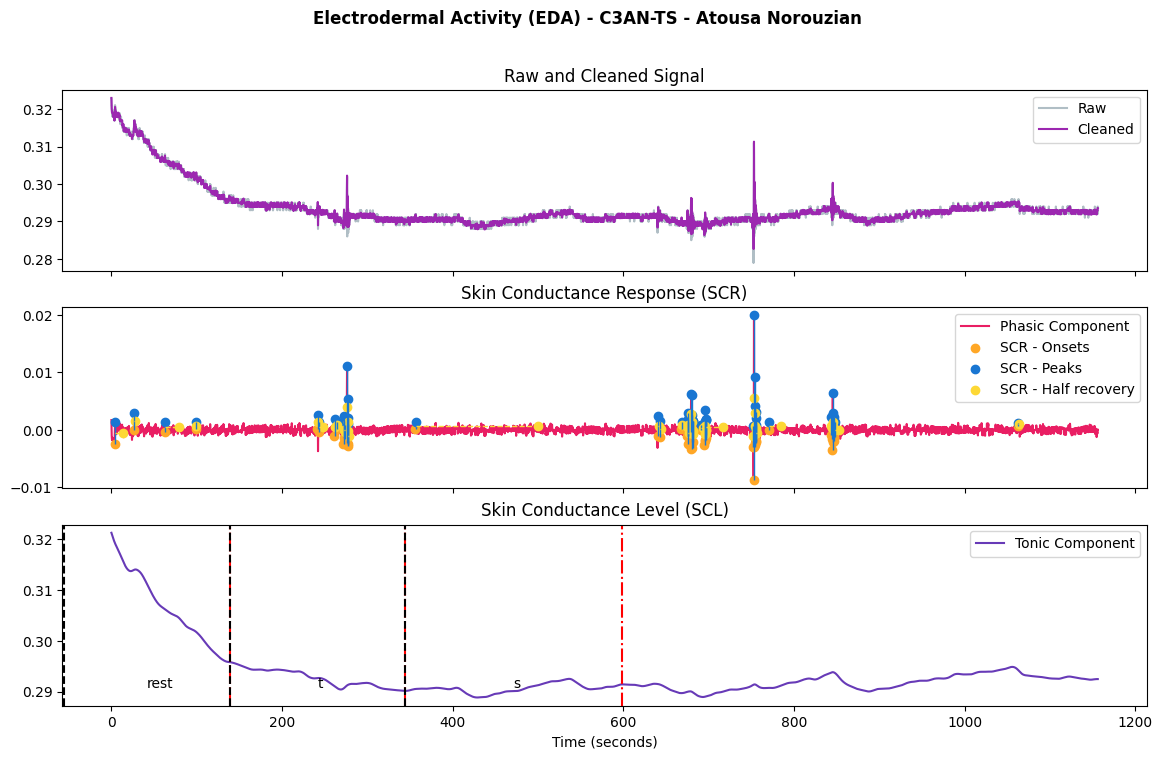

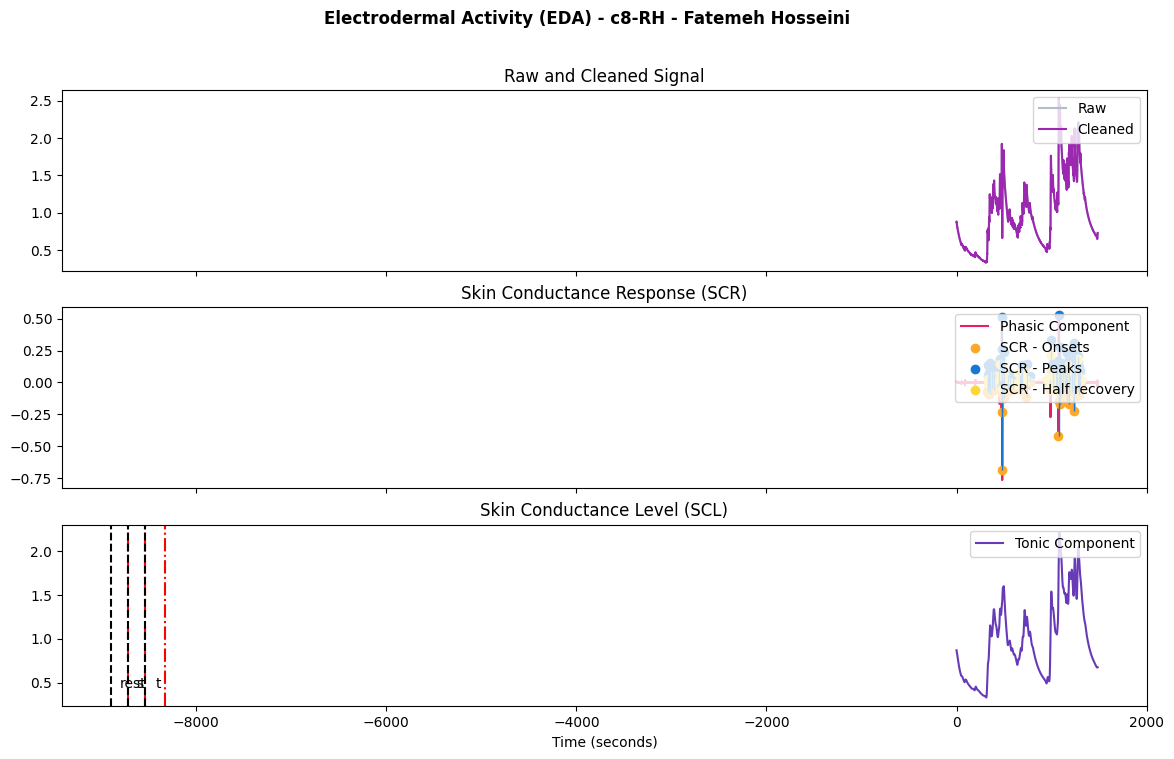

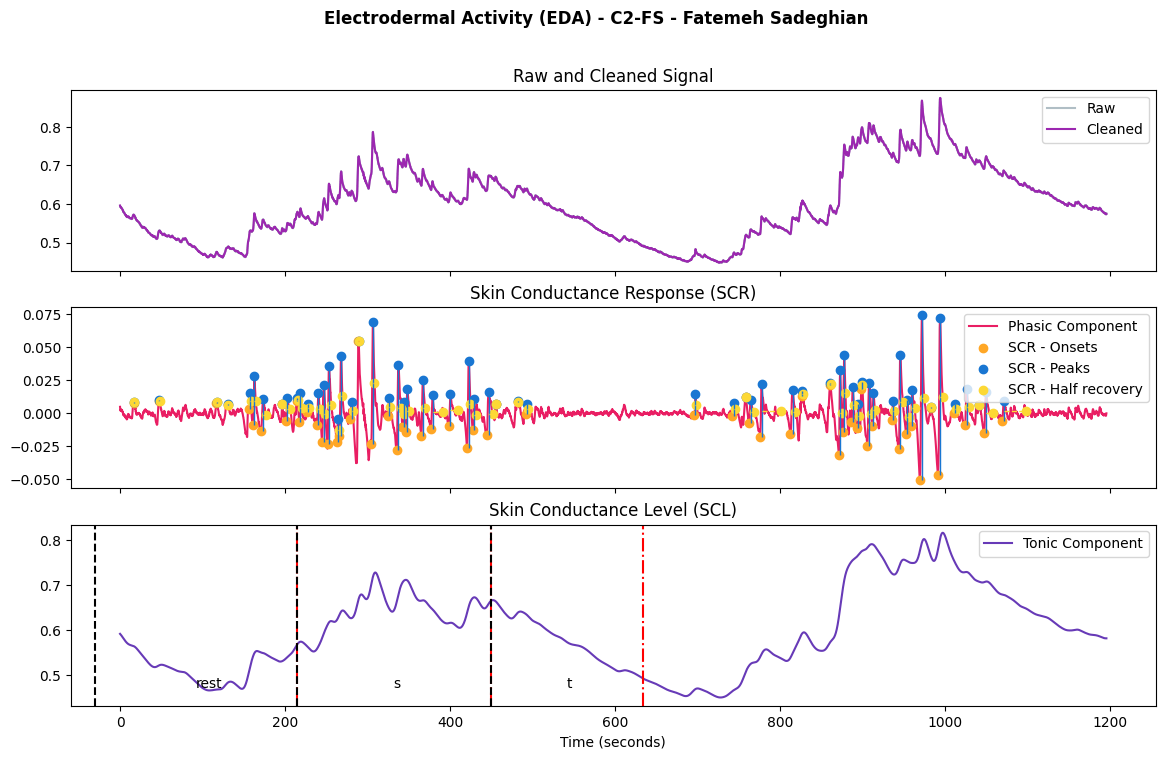

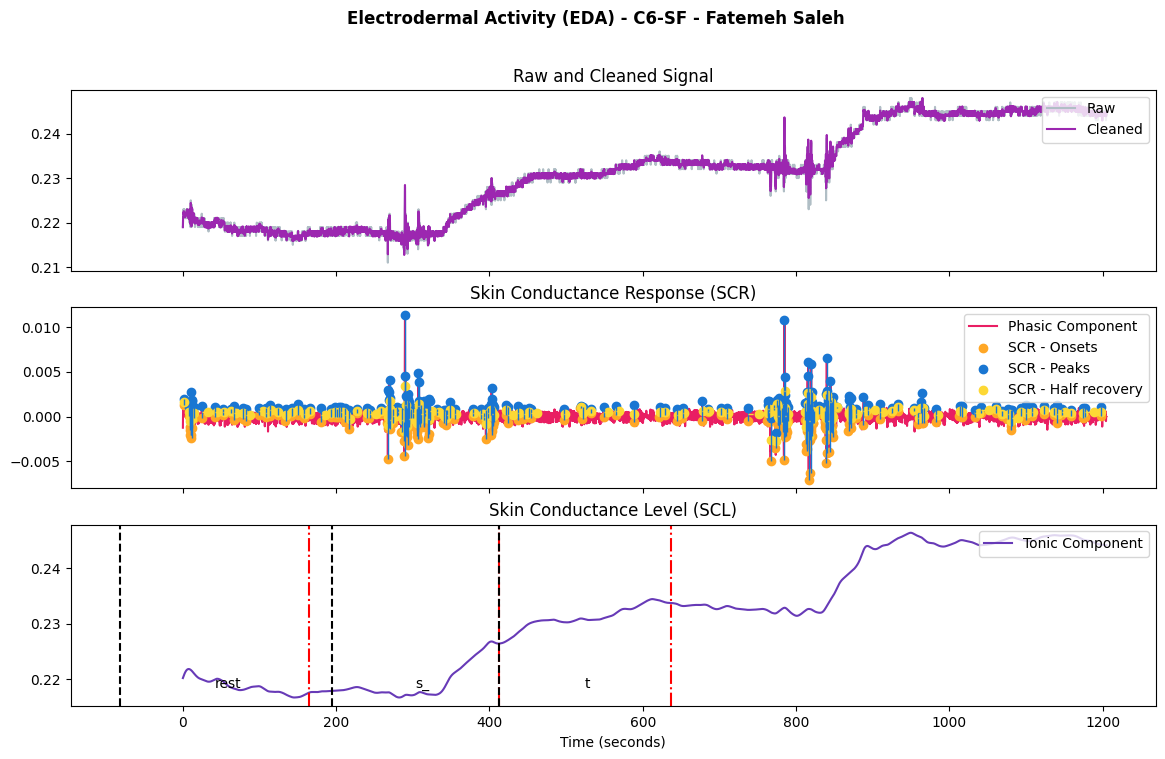

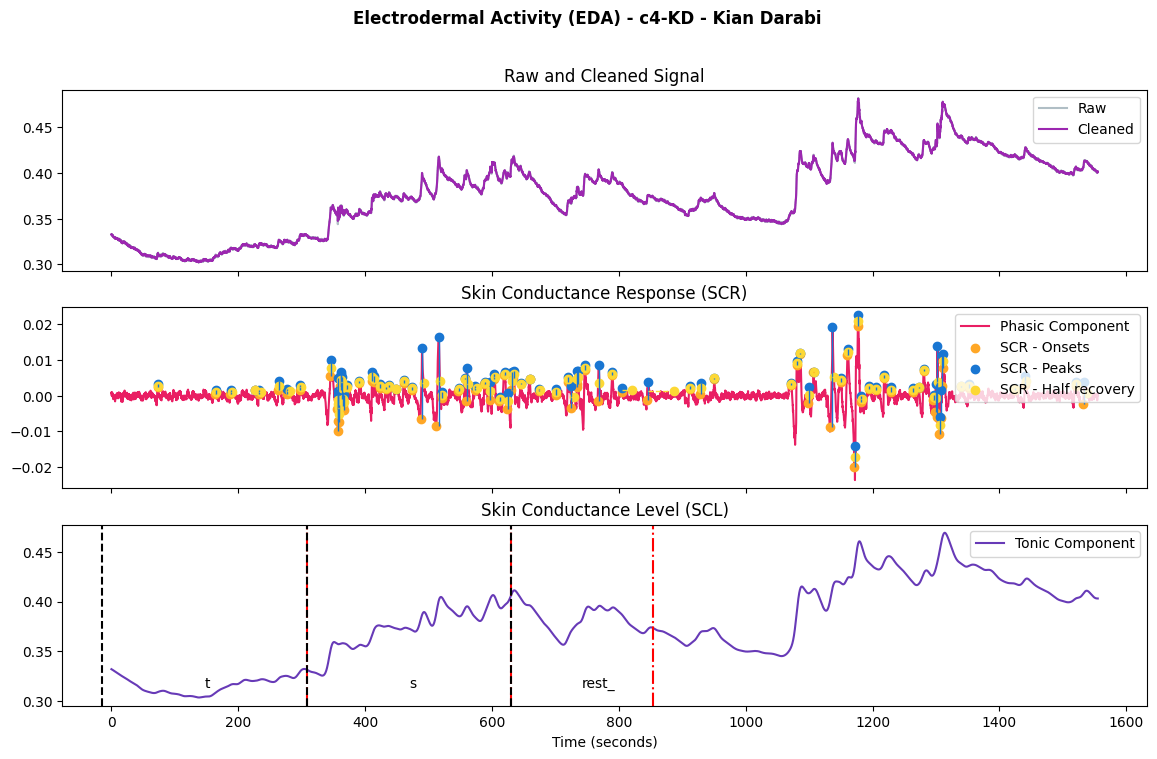

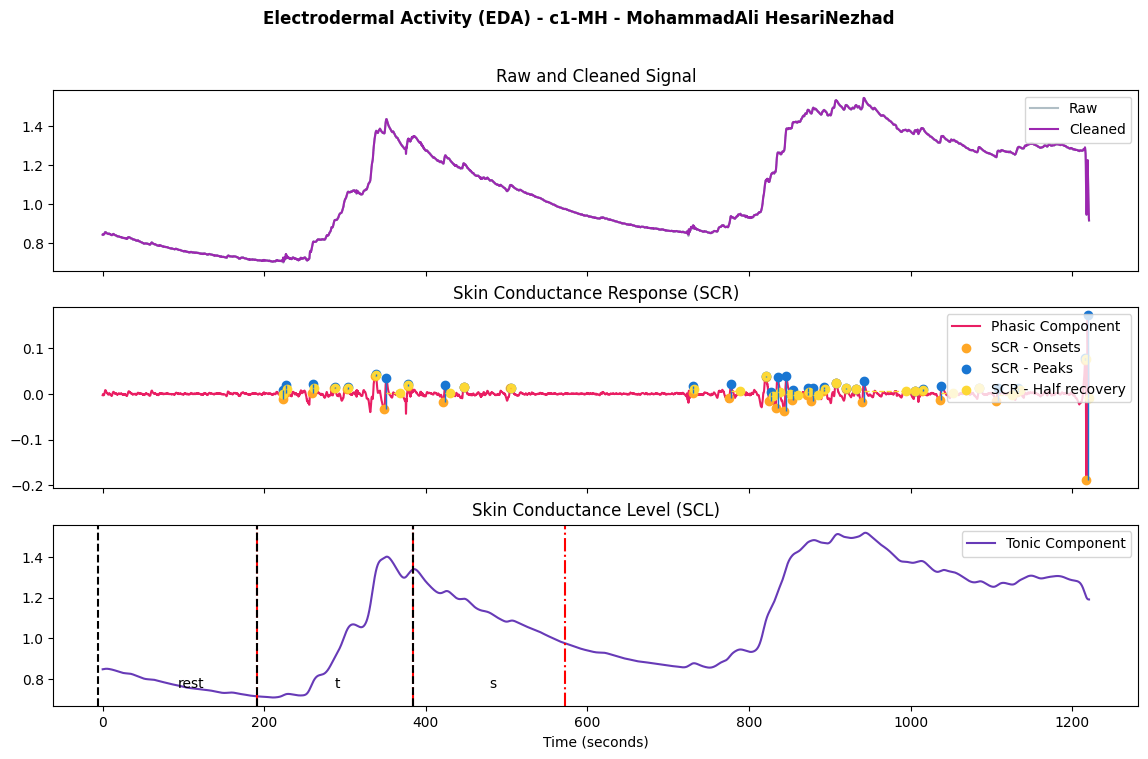

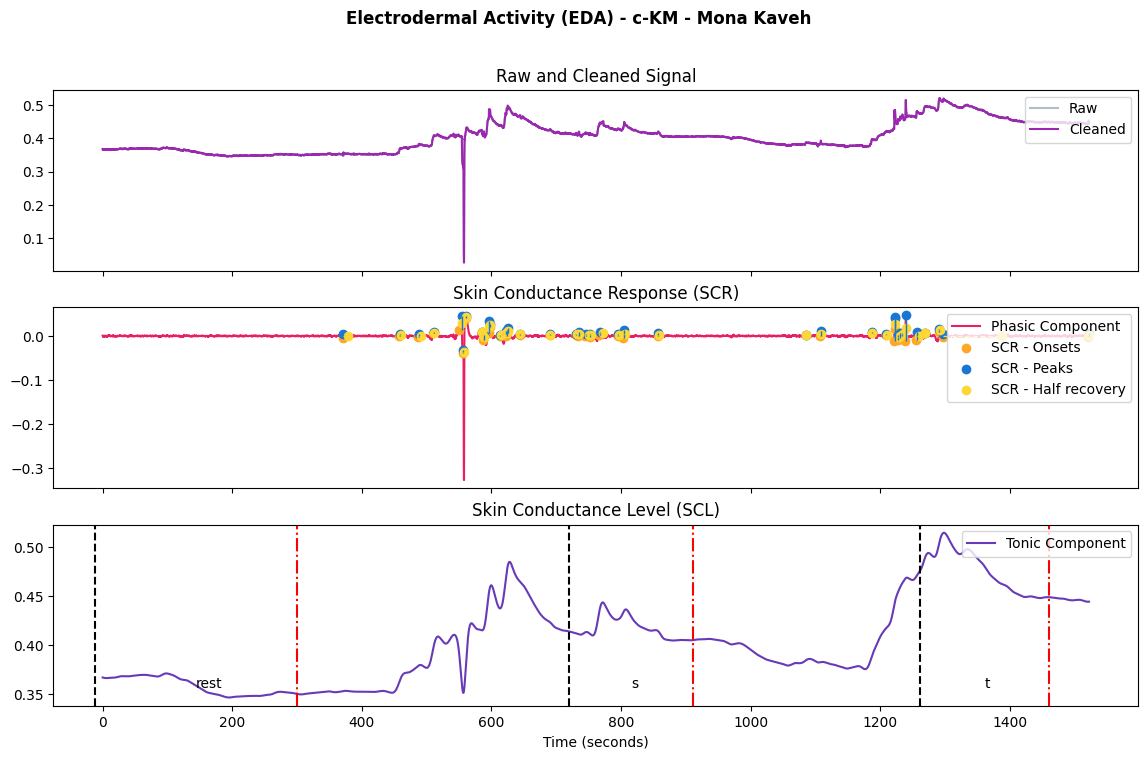

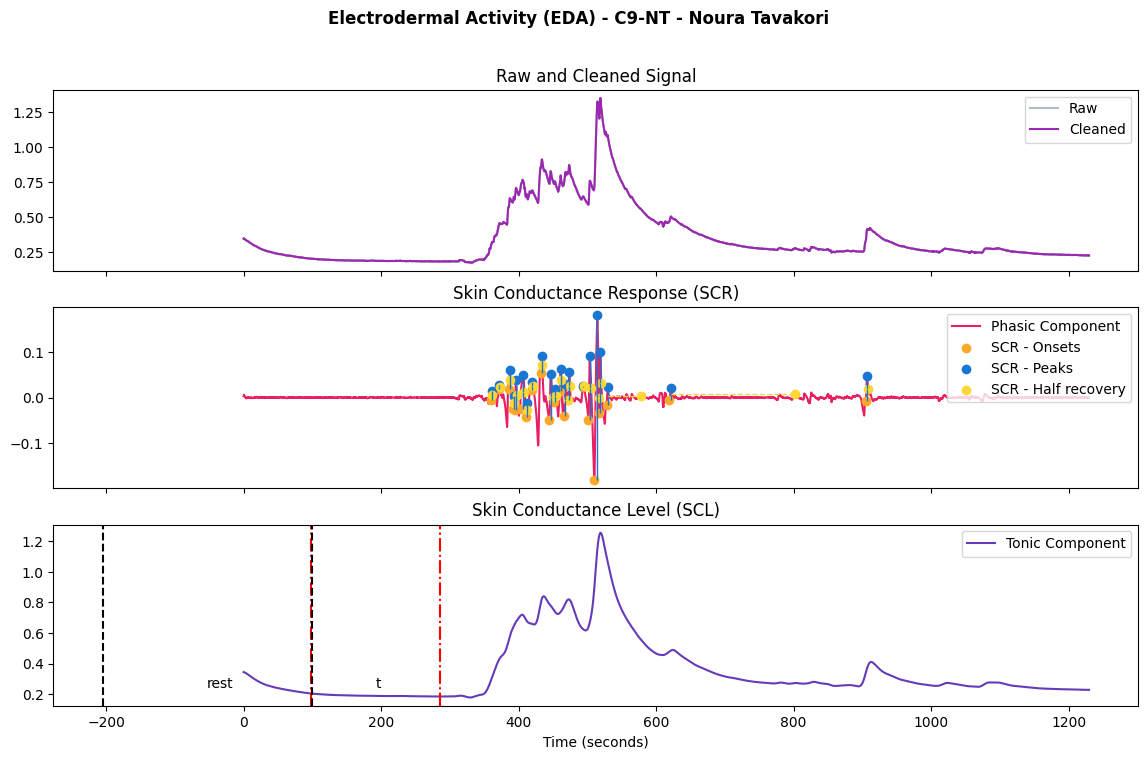

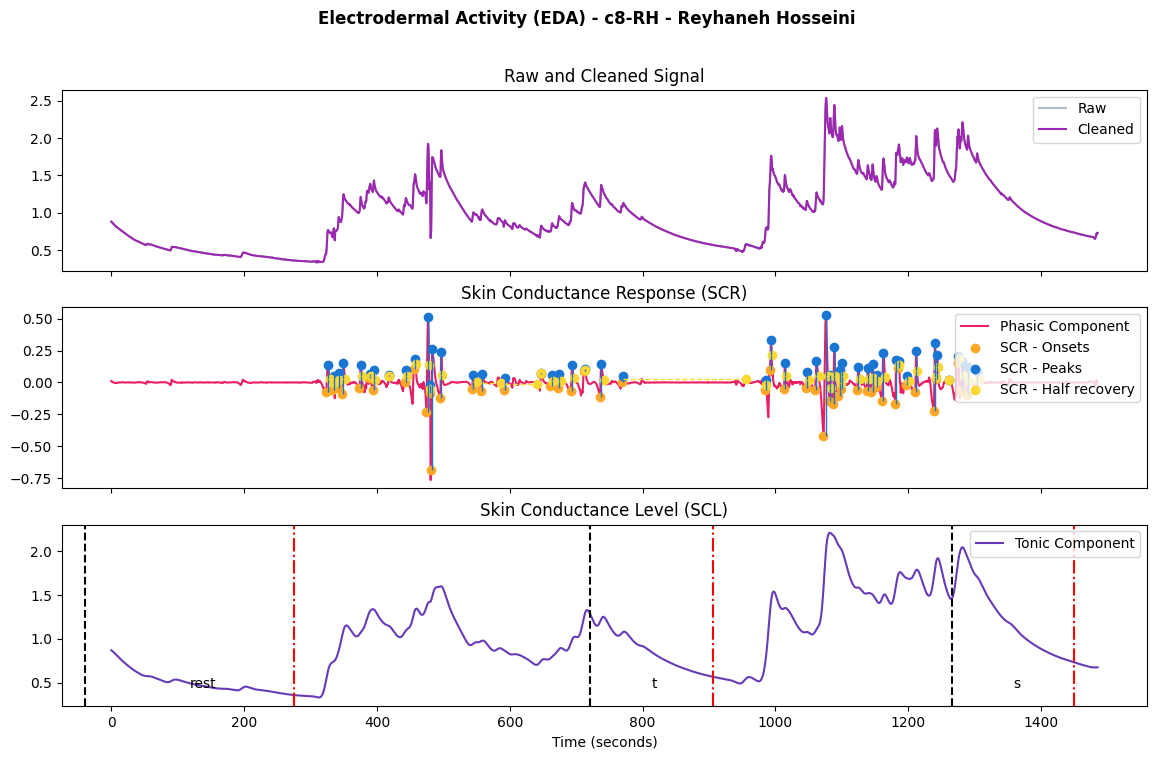

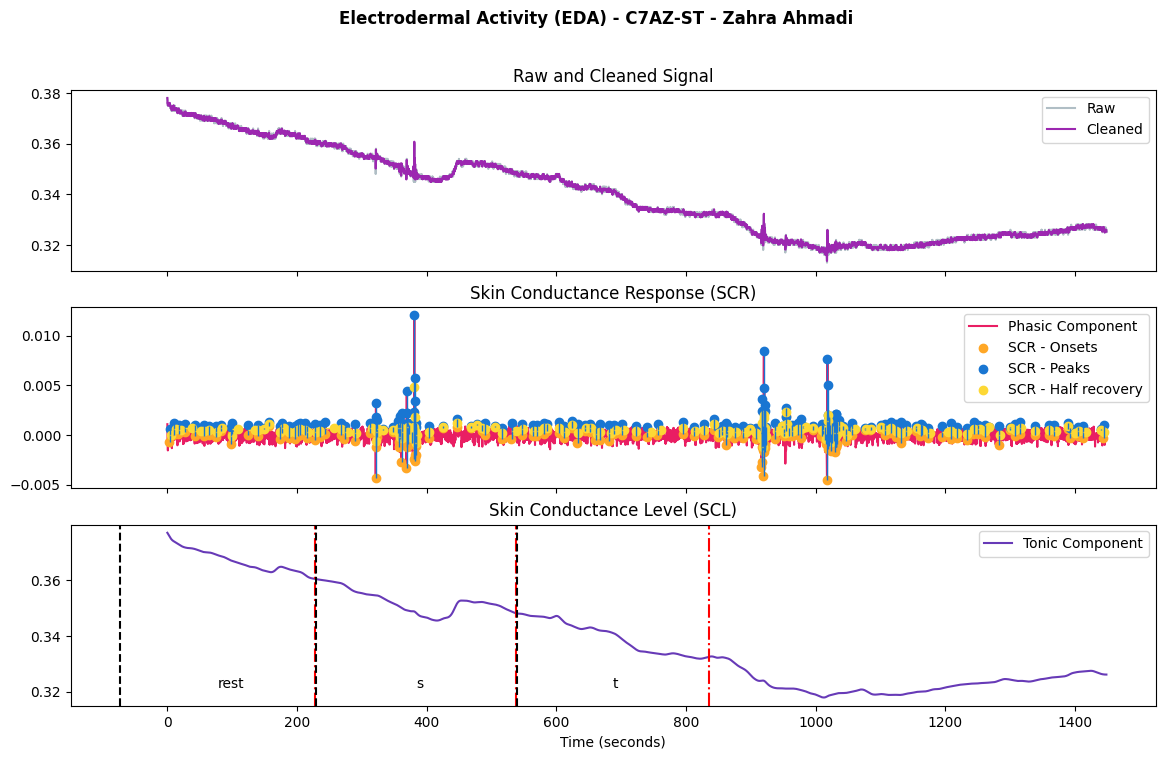

In [374]:
directory = "E:/Mitra/liquid-effect-on-eeg-analysis/assets/bio"
# directory = "../assets/bio"
for file_name in Path(directory).iterdir():
    client_name, eda_signals, info = parse_file(file_name)
    plot_data(eda_signals, info, client_name)